In [18]:
import keras_tuner as kt 
from yellowbrick.model_selection import RFECV
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import KFold
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, Input
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor
from scipy.stats import boxcox, yeojohnson
np.random.seed(42)

In [3]:
# The training data.
train = pd.read_csv('../data/Train.csv')
test = pd.read_csv('../data/Test.csv')
ss = pd.read_csv('../data/SampleSubmission.csv')
train.shape, test.shape


# // The training data has many features so that could lead to a curse of dimensionality 
    # // dimentionality reduction - PCA and other methods
    # // feature selection for importance features ()

((83148, 29), (25584, 28))

In [4]:
# // only the target is not present in the testing set

for column in train.columns:
    if column not in test.columns:
        print(column)

burn_area


In [5]:
# // Investigate missing values
    # // There are no missing values

train.isnull().any().any(), test.isnull().any().any(), ss.isnull().any().any()

(False, False, False)

In [6]:
# Look at distribution of each variable
train.describe()

,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,...,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation
count,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,...,83148.000000,83148.000000,83148.000000,8.314800e+04,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000
mean,-19.014557,29.860856,0.007632,484.491124,828.892721,-30.806237,1313.382992,54.576322,6.215134,305.477919,...,0.006158,0.000017,0.008583,4.066313e-08,0.160628,0.037453,0.785382,0.000354,0.001424,0.078551
std,1.588444,1.751090,0.029226,470.467480,546.934469,235.802930,315.209838,71.997561,21.480399,400.956123,...,0.053111,0.000141,0.059046,3.535121e-06,0.192957,0.106050,0.233953,0.001773,0.014233,0.104464
min,-22.358835,25.487029,0.000000,0.000000,0.000000,-563.000000,587.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000019,0.000000,0.000000,0.000000
25%,-20.358835,28.487029,0.000000,50.000000,375.000000,-212.000000,1081.000000,1.000000,0.000000,70.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.014993,0.000000,0.655322,0.000000,0.000000,0.002017
50%,-18.858835,29.987029,0.000000,302.000000,858.000000,-108.000000,1290.000000,22.000000,1.000000,149.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.076706,0.000139,0.880600,0.000000,0.000000,0.028503
75%,-17.858835,31.237029,0.000000,931.000000,1211.000000,142.000000,1517.000000,87.000000,4.000000,329.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.246498,0.015166,0.971209,0.000000,0.000000,0.125500
max,-15.858835,32.987029,0.843886,1713.000000,2614.000000,851.000000,2620.000000,501.000000,342.000000,3319.000000,...,0.828131,0.004918,0.711603,3.073689e-04,0.981472,0.881323,1.000000,0.016708,0.301823,0.801328


7.675599412401078


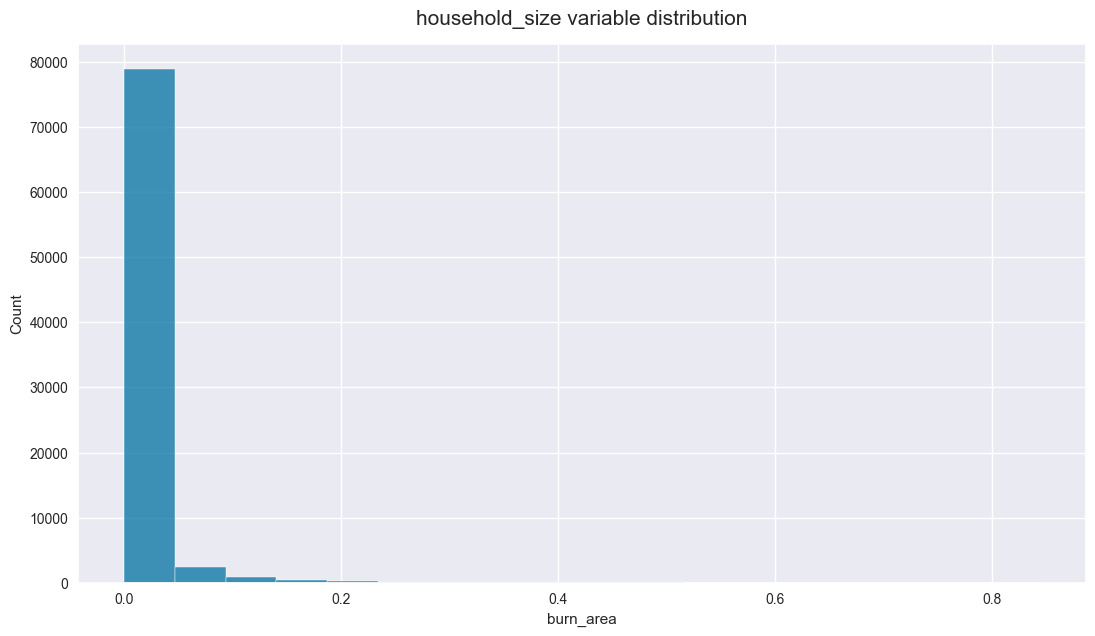

None

In [7]:
# // The target is highly skewed
    # // we need to transform it

print(train.burn_area.skew())

sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(train.burn_area)
plt.title('household_size variable distribution', y = 1.02, fontsize = 15)
display(plt.show())

In [ ]:
# Look at correlation with target
train.select_dtypes(include=['number']).corr()['burn_area'].sort_values().plot(kind='bar', figsize=(18, 6))

##  Adding date features

In [8]:
# Split the ID (eg 127_2017-01-03) to get the date string, which we convert to datetime to make life easier
train['date'] = pd.to_datetime(train['ID'].apply(lambda x: x.split('_')[1]))
test['date'] = pd.to_datetime(test['ID'].apply(lambda x: x.split('_')[1]))
train['burn_area'] = pd.to_numeric(train['burn_area'], errors='coerce')


# Date variables
train['month'] = train.date.dt.month
train['year'] = train.date.dt.year
train['day'] = train.date.dt.weekday

In [1]:
# // Discretization

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans


def optimal_k(data: pd.DataFrame, column: str, max_k: int=10):
    silhouette_scores = []
    X = data[column].values.reshape(-1, 1)
    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        score = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append(score)
        optimal_k = range(2, max_k+1)[silhouette_scores.index(max(silhouette_scores))]
    return optimal_k


def binning(data: pd.DataFrame) -> pd.DataFrame:
    numerics = []
    for i in data.columns:
        if data[i].dtype == 'float' or data[i].dtype == 'int':
            numerics.append(i)

    for column in numerics:
        k = optimal_k(data, column)
        reshaped_data = data[column].values.reshape(-1, 1)
        kmeans = KMeans(n_clusters=k, random_state=42)
        data[column] = kmeans.fit_predict(reshaped_data)
    return data


train = binning(train)

In [ ]:
# // Handling outliers
    # // find other methods as well


def capping(data: pd.DataFrame) -> pd.DataFrame:
    numerics = []
    for col in data.columns:
        if data[col].dtype == 'float' or data[col].dtype == 'int':
            numerics.append(col)

    for col in numerics:
        q1 = data[col].quantile(0.25)
        q2 = data[col].quantile(0.75)
        iqr = q2 - q1
        max_limit = q2 + (1.5 * iqr)
        min_limit = q1 - (1.5 * iqr)
        data[col]  = pd.DataFrame(
            np.where(data[col] > max_limit, max_limit,
            (np.where(data[col] < min_limit, min_limit, data[col]))), columns=[col]
        )
    return data
train = capping(train)

## Machine Learning

In [9]:
# // Splitting the data into training and testing sets

train_all = train.copy().dropna()
train = train_all.loc[train_all.date < '2011-01-01']
valid = train_all.loc[train_all.date > '2011-01-01']
print(train.shape, valid.shape)

(63960, 33) (18655, 33)


In [12]:
# Define input and output columns - you can play with adding or removing inputs to the model
in_cols = ['climate_aet', 'climate_def', 
       'climate_pdsi', 'climate_pet', 'climate_pr', 'climate_ro',
       'climate_soil', 'climate_srad', 'climate_swe', 'climate_tmmn',
       'climate_tmmx', 'climate_vap', 'climate_vpd', 'climate_vs', 'elevation',
       'landcover_0', 'landcover_1', 'landcover_2', 'landcover_3',
       'landcover_4', 'landcover_5', 'landcover_6', 'landcover_7',
       'landcover_8', 'precipitation'] # 'month', 'year', 'day', 'date'
target_col = 'burn_area'


X_train, y_train = train[in_cols], train[target_col]
X_valid, y_valid = valid[in_cols], valid[target_col]



KeyboardInterrupt: 

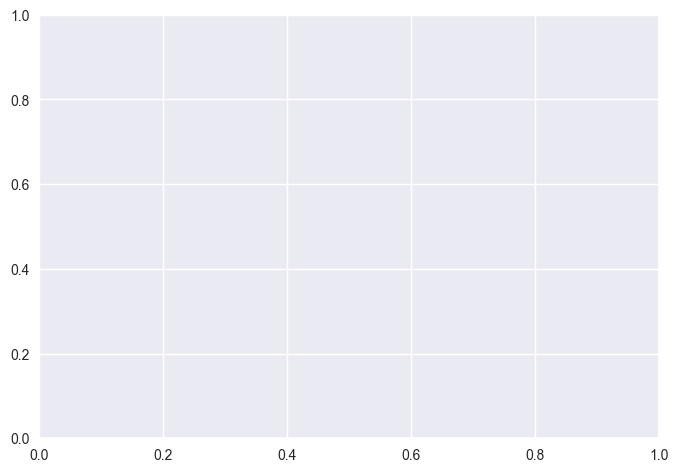

In [16]:
# // Feature selection

visualizer = RFECV(
    RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1, criterion='squared_error'),
    step=1, cv=3, scoring="neg_root_mean_squared_log_error"
)
visualizer.fit(X_train, y_train)
plt.figure(figsize=[5.6, 4])
visualizer.show()


In [17]:

def feature_selection(X_train, X_test, y_train, index: int=train.shape[1]) -> tuple:
    sel = RFE(
        estimator=RandomForestRegressor(
            n_estimators=100, random_state=42, n_jobs=-1
        ),
        n_features_to_select=index
    )
    sel.fit(X_train, y_train)
    X_train_rfe = sel.transform(X_train) 
    X_test_rfe = sel.transform(X_test)
    return X_train_rfe, X_test_rfe

feature_selection(X_train, X_valid, y_train, index=7)

NameError: name 'RFE' is not defined

In [19]:

def scaler(X_train, X_test, minmax: bool=False):
    stdscaler = StandardScaler()
    X_train = stdscaler.fit_transform(X_train)
    X_test = stdscaler.transform(X_test)

    if minmax:
        minmaxscaler = MinMaxScaler(feature_range=(0,1))
        X_train = minmaxscaler.fit_transform(X_train)
        X_test = minmaxscaler.transform(X_test)
    return X_train, X_test

X_train, X_valid = scaler(X_train=X_train, X_test=X_valid, minmax=True)

In [20]:
# // PCA


pca = PCA(n_components=1, random_state=42)
pca = pca.fit(X_train)
X_train = pca.transform(X_train)
X_valid = pca.transform(X_valid)

In [21]:

# Create and fit the model
model = RidgeCV()
model.fit(X_train, y_train)
preds = model.predict(X_valid)
mean_squared_error(y_valid, preds)**0.5

0.02855558927221779

In [22]:

# Create and fit the model
random_F = RandomForestRegressor(random_state=42)
random_F.fit(X_train, y_train)
preds = random_F.predict(X_valid)
mean_squared_error(y_valid, preds)**0.5

0.03485312434643454

In [ ]:

# Create and fit the model
svr = SVR(kernel='poly', gamma='auto', C=10)
svr.fit(X_train, y_train)
preds = svr.predict(X_valid)
mean_squared_error(y_valid, preds)**0.5

0.07291198056640737

In [24]:


ada = AdaBoostRegressor(random_state=42, estimator=random_F, learning_rate=1e-4)
ada.fit(X_train, y_train)
preds = ada.predict(X_valid)
print(mean_squared_error(y_valid, preds)**0.5 )



# // model with box-cox

y_train_boxcox, lambda_boxcox = boxcox(y_train)
y_valid_boxcox = boxcox(y_valid, lmbda=lambda_boxcox)

ada.fit(X_train, y_train_boxcox)
preds = ada.predict(X_valid)
print(mean_squared_error(y_valid_boxcox, preds)**0.5 )
preds_original_scale = np.exp(np.log(preds) * lambda_boxcox + 1) / lambda_boxcox



# // model with yeojohnson

y_train_yeojohnson, lambda_boxcox = yeojohnson(y_train)
y_valid_yeojohnson = boxcox(y_valid, lmbda=lambda_boxcox)

ada.fit(X_train, y_train_yeojohnson)
preds = ada.predict(X_valid)
print(mean_squared_error(y_valid_yeojohnson, preds)**0.5) 
preds_original_scale = np.exp(np.log(preds) * lambda_boxcox + 1) / lambda_boxcox

0.034265737794293684


ValueError: Data must be positive.

In [25]:
# // model with yeojohnson

y_train_yeojohnson, lambda_boxcox = yeojohnson(y_train)
y_valid_yeojohnson = boxcox(y_valid, lmbda=lambda_boxcox)

ada.fit(X_train, y_train_yeojohnson)
preds = ada.predict(X_valid)
print(mean_squared_error(y_valid_yeojohnson, preds)**0.5) 
preds_original_scale = np.exp(np.log(preds) * lambda_boxcox + 1) / lambda_boxcox

In [ ]:


kn = KNeighborsRegressor(n_neighbors=3)
kn.fit(X_train, y_train)
preds = kn.predict(X_valid)
mean_squared_error(y_valid, preds)**0.5

0.026961837079682565

In [ ]:
# // more models

def grid_search(model, params):
    grid = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid.best_estimator_, grid.best_params_, np.sqrt(-grid.best_score_)


models = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {}
    },
    "Ridge Regression": {
        "model": Ridge(random_state=42, alpha=1, solver='svd'),
        "params": {"alpha": [0.1, 1, 10, 100]}
    },
    "Random Forest Regression": {
        "model": RandomForestRegressor(random_state=42),
        "params": {"n_estimators": [10, 50, 100], "max_depth": [None, 10, 20, 30]}
    },
    "Gradient Boosting Regression": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1], "max_depth": [3, 5, 7]}
    },
    "K-Nearest Neighbors Regression": {
        "model": KNeighborsRegressor(),
        "params": {"n_neighbors": [3, 5, 7], "weights": ['uniform', 'distance']}
    },
    "LGBMRegressor": {
        "model": lgb.LGBMRegressor(),
        "params": {
                    'num_leaves': [31, 50, 70],
                    'learning_rate': [0.01, 0.05, 0.1],
                    'n_estimators': [100, 200, 500],
                    'max_depth': [-1, 10, 20],
                    'min_child_samples': [20, 50, 100],
                    'subsample': [0.6, 0.8, 1.0],
                    'colsample_bytree': [0.6, 0.8, 1.0]
                }
    },
    "": {
        "model": xgb.XGBRegressor(),
        "params": {
            'n_estimators': [100, 200, 500],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'min_child_weight': [1, 3, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'gamma': [0, 0.1, 0.2]
        }
    }
}

In [ ]:
# // Hyper-parameter tuning


results = {}
for name, config in models.items():
    model, params, score = grid_search(config['model'], config['params'])
    results[name] = {'Best Model': model, 'Best Params': params, 'RMSE': score}

# Print the results
for name, result in results.items():
    print(f"{name} - Best Params: {result['Best Params']}, RMSE: {result['RMSE']}")


best_model_name = min(results, key=lambda x: results[x]['RMSE'])
best_model = results[best_model_name]['Best Model']
test_rmse = np.sqrt(mean_squared_error(y_valid, best_model.predict(X_valid)))

print(f"\nBest Model: {best_model_name}")
print(f"Test RMSE: {test_rmse}")

Linear Regression - Best Params: {}, RMSE: 0.02733069747339375
Ridge Regression - Best Params: {'alpha': 100}, RMSE: 0.027330800334030417
Random Forest Regression - Best Params: {'max_depth': 10, 'n_estimators': 100}, RMSE: 0.026179369068177295
Gradient Boosting Regression - Best Params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}, RMSE: 0.025617402169930487
K-Nearest Neighbors Regression - Best Params: {'n_neighbors': 7, 'weights': 'distance'}, RMSE: 0.025250276182806154

Best Model: K-Nearest Neighbors Regression
Test RMSE: 0.02514277990263765


In [ ]:

# // Cross-validation


X = train[in_cols]
y = train['burn_area']
cv = KFold(n_splits=10, shuffle=False)

scores = []
for train_index, test_index in cv.split(X=X, y=y):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]

        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        print(mean_squared_error(y_test, preds)**0.5)
        scores.append(mean_squared_error(y_test, preds)**0.5)

print("The average score is {}".format(np.mean(scores)))

## Deep Learning

In [ ]:


input_dim = X_train.shape[1]
noise_factor = 0.1
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_valid.shape)
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)


input_data = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_data)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)  # Bottleneck
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)
autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train_noisy, X_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_noisy, X_valid))


encoder = Model(input_data, encoded)
X_train_encoded = encoder.predict(X_train_noisy)
X_valid_encoded = encoder.predict(X_test_noisy)


model = Sequential()
model.add(Dense(units=512, activation='relu', input_shape=(X_train_encoded.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))
model.add(Dense(units=64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(units=32, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_encoded, y_train, epochs=50, batch_size=256, validation_data=(X_valid_encoded, y_valid))


preds = model.predict(X_valid_encoded)
rmse = mean_squared_error(y_valid, preds)**0.5
print(f'RMSE: {rmse}')


In [ ]:
# // Hyper-parameter tuning - Keras-tuner



def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', min_value=128, max_value=512, step=32),
        activation='relu', 
        input_shape=(X_train_encoded.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(
        units=hp.Int('units_2', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(Dense(
        units=hp.Int('units_3', min_value=16, max_value=64, step=16),
        activation='relu'
    ))
    model.add(Dense(1, activation='linear'))
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
        loss='mean_squared_error'
    )
    
    return model


tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='hyperparameter_tuning'
)

tuner.search(X_train_encoded, y_train, epochs=50, validation_data=(X_valid_encoded, y_valid))
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_encoded, y_train, epochs=50, validation_data=(X_valid_encoded, y_valid))
eval_result = model.evaluate(X_valid_encoded, y_valid)
print(f"Test RMSE: {eval_result**0.5}")


# Submission

In [ ]:


test = test.drop(['ID'], axis=1)
test['month'] = test.date.dt.month
test['year'] = test.date.dt.year
test['data'] = test.date.dt.dayofweek


test = pca.transform(test[in_cols])
preds = model.predict(test)#[in_cols].fillna(0))
ss['burn_area'] = preds

ss['burn_area'] = ss['burn_area'].clip(0, 1)
ss.to_csv('starter_submission.csv', index=False)